<img width="150" alt="Logo_ER10" src="https://user-images.githubusercontent.com/3244249/151994514-b584b984-a148-4ade-80ee-0f88b0aefa45.png">

### Interpreting a leaf identification model with LIME
This notebook demonstrates the use of DIANNA with the LIME timeseries method on the coffee dataset.

LIME (Local Interpretable Model-agnostic Explanations) is an explainable-AI method that aims to create an interpretable model that locally represents the classifier. For more details see the [LIME paper](https://arxiv.org/abs/1602.04938).

*NOTE*: This tutorial is still work-in-progress, the final results need to be improved by tweaking the LIME parameters

#### 1. Imports and paths

In [3]:
import dianna
from pathlib import Path
import pandas as pd
import sklearn
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import accuracy_score as acc
import numpy as np

#### 2. Loading the data

In [4]:
# Load coffee dataset
path_to_data = "data"
coffee_train = pd.read_csv(Path(path_to_data, "coffee_train.csv"),
                            sep=',', header=None).astype(float)
coffee_train_y = coffee_train.loc[:, 0]
coffee_train_x = coffee_train.loc[:, 1:]
coffee_test = pd.read_csv(Path(path_to_data, "coffee_test.csv"),
                           sep=',', header=None).astype(float)
coffee_test_y = coffee_test.loc[:, 0]
coffee_test_x = coffee_test.loc[:, 1:]

In [5]:
# Define and train model
knn = KNN()
knn.fit(coffee_train_x, coffee_train_y)
print('Accuracy KNN for coffee dataset: %f' % (acc(coffee_test_y, knn.predict(coffee_test_x))))

Accuracy KNN for coffee dataset: 0.964286


In [6]:
# Select instance for explanation
idx = 5 # explained instance
num_features = 50 # how many feature contained in explanation
series = coffee_test_x.iloc[idx, :]
num_slices = len(series) # split time series

class_names = ['Arabica', 'Robusta']
labels = np.argsort(class_names)
series.shape

(286,)

In [5]:
type(knn.predict_proba)

method

#### 3. Applying LIME with DIANNA

In [7]:
exp = dianna.explain_timeseries(knn.predict_proba, timeseries_data=series, method='lime',
                                labels=[0,1], class_names=class_names, num_features=num_features,
                                num_samples=5000, num_slices=num_slices, distance_method='cosine')

/home/cpranav93/miniconda3/envs/dianna-dev/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### 4. Plot results 

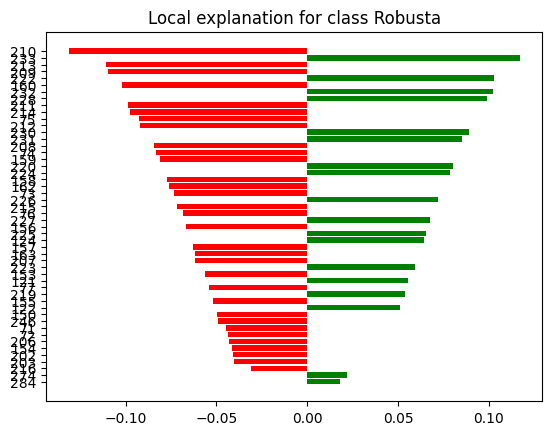

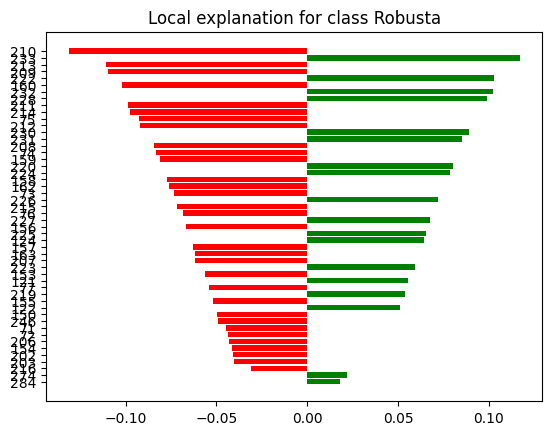

In [8]:
import matplotlib.pyplot as plt
exp.as_pyplot_figure()

1


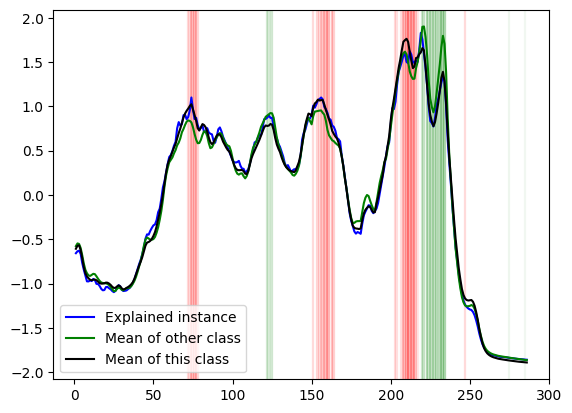

In [9]:
import math
values_per_slice = math.ceil(len(series) / num_slices)
print (values_per_slice)
plt.plot(series, color='b', label='Explained instance')
plt.plot(coffee_test_x.iloc[15:,:].mean(), color='green', label='Mean of other class')
plt.plot(coffee_test_x.iloc[:14,:].mean(), color='black', label='Mean of this class')
plt.legend(loc='lower left')

for i in range(num_features):
    feature, weight = exp.as_list()[i]
    start = feature * values_per_slice
    end = start + values_per_slice
    color = 'red' if weight < 0 else 'green' 
    plt.axvspan(start , end, color=color, alpha=abs(weight*2))
plt.show()

Experiment with ONNX <br>
The model is trained following this notebook: <br>
https://github.com/dianna-ai/dianna-exploration/blob/main/example_data/model_generation/coffee/generate_model.ipynb

In [10]:
from dianna.utils.onnx_runner import SimpleModelRunner
import numpy as np

model_path = 'coffee.onnx'
loaded_model = SimpleModelRunner(model_path)
coffee_train_x_numpy = coffee_train_x.to_numpy().astype(np.float32)
predictions = loaded_model(coffee_train_x_numpy)

In [11]:
import onnxruntime as ort

def run_model(data):
    # model must receive input in the order of [batch, timeseries, channels]
    # data = data.transpose([0,2,1])
    # get ONNX predictions
    sess = ort.InferenceSession(model_path)
    input_name = sess.get_inputs()[0].name
    output_name = sess.get_outputs()[0].name

    onnx_input = {input_name: data.astype(np.float32)}
    pred_onnx = sess.run([output_name], onnx_input)[0]
    
    return pred_onnx

In [12]:
exp = dianna.explain_timeseries(run_model, timeseries_data=coffee_train_x_numpy[:1], method='lime',
                                labels=[0], class_names=class_names[1], num_features=num_features,
                                num_samples=10, num_slices=num_slices, distance_method='cosine')

/home/yangliu/MLexpo/dianna/dianna/utils/maskers.py:62: UserWarning: Warning: p_keep chosen too high. Continuing with masking 1 time step per mask.
  warnings.warn('Warning: p_keep chosen too high. Continuing with masking 1 time step per mask.')
Explaining: 100%|██████████| 10/10 [00:00<00:00, 339.14it/s]


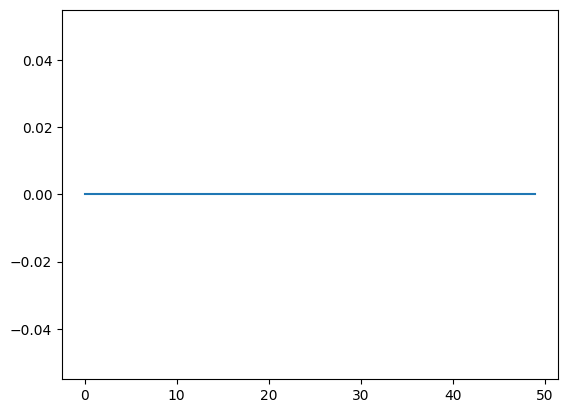

In [13]:
results = exp.local_exp[0]
results = [i for _, i in exp.local_exp[0]]
plt.plot(results)